# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# Data Seperation and sorting

In [2]:
# Load the clean data
conn = sqlite3.connect('final.sqlite')
clean_data = pd.read_sql_query(""" SELECT * FROM Reviews_clean WHERE Score != 3 """, conn) 

In [11]:
clean_data.head(1)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...


In [50]:
# Checking the positive and negative labels
clean_data['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [176]:
#Randomly selecting 40k records
filter_data_positive=clean_data[clean_data.Score==1].sample(50000,random_state=17)
filter_data_positive.sort_values(by='Time',inplace=True,ascending=True)

In [177]:
#selecting all -ve records records
filter_data_negative=clean_data[clean_data.Score==0].sample(50000,random_state=17)
filter_data_negative.sort_values(by='Time',inplace=True,ascending=True)

In [178]:
# Splitting Train,CV and Test for positive data
row=filter_data_positive.shape[0]
split=int(row*0.6)
train_data_positive=filter_data_positive[:split]
cv_data_positive=filter_data_positive[split:int(row*0.8)]
test_data_positive=filter_data_positive[int(row*0.8):row]
print("Total_positive_data",filter_data_positive.shape)
print("train",train_data_positive.shape,"CV",cv_data_positive.shape,"test",test_data_positive.shape)

Total_positive_data (50000, 12)
train (30000, 12) CV (10000, 12) test (10000, 12)


In [179]:
# Splitting Train,CV and Test for -ve data
row=filter_data_negative.shape[0]
split=int(row*0.6)
train_data_negative=filter_data_negative[:split]
cv_data_negative=filter_data_negative[split:int(row*0.8)]
test_data_negative=filter_data_negative[int(row*0.8):row]
print("Total_negative_data",filter_data_negative.shape)
print("train",train_data_negative.shape,"CV",cv_data_negative.shape,"test",test_data_negative.shape)

Total_negative_data (50000, 12)
train (30000, 12) CV (10000, 12) test (10000, 12)


In [180]:
# Combining +ve and -ve train data and sorting based on time
train_data=np.vstack((train_data_positive, train_data_negative))
train_data=pd.DataFrame(train_data)
train_data.columns=clean_data.columns
train_data.sort_values(by='Time',inplace=True,ascending=True)
print(train_data.shape)
# Checking the positive and negative labels
train_data['Score'].value_counts()

(60000, 12)


1    30000
0    30000
Name: Score, dtype: int64

In [181]:
# Combining +ve and -ve CV data and sorting based on time
cv_data=np.vstack((cv_data_positive,cv_data_negative))
cv_data=pd.DataFrame(cv_data)
cv_data.columns=clean_data.columns
cv_data.sort_values(by='Time',inplace=True,ascending=True)
print(cv_data.shape)
# Checking the positive and negative labels
cv_data['Score'].value_counts()

(20000, 12)


1    10000
0    10000
Name: Score, dtype: int64

In [182]:
# Combining +ve and -ve test data and sorting based on time
test_data=np.vstack((test_data_positive, test_data_negative))
test_data=pd.DataFrame(test_data)
test_data.columns=clean_data.columns
test_data.sort_values(by='Time',inplace=True,ascending=True)
print(test_data.shape)
# Checking the positive and negative labels
test_data['Score'].value_counts()

(20000, 12)


1    10000
0    10000
Name: Score, dtype: int64

In [41]:
# # Saving to file to reuse in other assignment
# train_data.to_csv("train_data.csv",index=False)
# cv_data.to_csv("cv_data.csv",index=False)
# test_data.to_csv("test_data.csv",index=False)

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [193]:
# Please write all the code with proper documentation
import gc; gc.collect()
# Converting text to vector using Bag of words to all train, CV and test
count_vect = CountVectorizer(min_df=10,max_features=1000 ) #in scikit-learn
training_counts = count_vect.fit_transform(train_data['CleanedText'])
cv_counts = count_vect.transform(cv_data['CleanedText'])
test_counts = count_vect.transform(test_data['CleanedText'])
gc.collect()

0

In [260]:
# converting sparse vector to dense vector
training_count=training_counts.toarray()
print(" training_counts ",training_counts.shape,"cv_counts ",cv_counts.shape,"test_counts",test_counts.shape)

 training_counts  (60000, 1000) cv_counts  (20000, 1000) test_counts (20000, 1000)


In [195]:
cv_count=cv_counts.toarray()
test_count=test_counts.toarray()
# removing unused object
gc.collect()

0

In [196]:
train_traget=train_data['Score'].astype('int')
cv_target=cv_data['Score'].astype('int')
test_target=test_data['Score'].astype('int')

In [197]:
gc.collect()

0

In [200]:
# Compute train AUC also

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
alpha=[0.0001,0.001,0.01,0.1,1,10,100,1000]
returned_pram=dict()
returned_pram_train=dict()
for i in tqdm(alpha):
    # instantiate learning model (k = 30)
    mnNB = MultinomialNB(alpha=i)

    # fitting the model on crossvalidation train
    mnNB.fit(training_count, train_traget)

    # predict the response on the crossvalidation train
    pred_cv = mnNB.predict(cv_count)

    # evaluate CV accuracy
    acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
    auc_cv=roc_auc_score(cv_target, pred_cv)
    auc_train=roc_auc_score(train_traget, mnNB.predict(training_count))
    print(" Alpha value: ",i," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
    returned_pram.update({i:auc_cv})
    returned_pram_train.update({i:auc_train})
    gc.collect()
    

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

 Alpha value:  0.0001  AUC:  0.8418500000000002  Acc:  84.185  auc_train  0.8441333333333333


 12%|██████████▌                                                                         | 1/8 [00:02<00:14,  2.04s/it]

 Alpha value:  0.001  AUC:  0.8418500000000002  Acc:  84.185  auc_train  0.8441333333333333


 25%|█████████████████████                                                               | 2/8 [00:04<00:12,  2.04s/it]

 Alpha value:  0.01  AUC:  0.8418500000000002  Acc:  84.185  auc_train  0.84415


 38%|███████████████████████████████▌                                                    | 3/8 [00:06<00:10,  2.06s/it]

 Alpha value:  0.1  AUC:  0.8418500000000002  Acc:  84.185  auc_train  0.84415


 50%|██████████████████████████████████████████                                          | 4/8 [00:08<00:08,  2.06s/it]

 Alpha value:  1  AUC:  0.8419500000000001  Acc:  84.195  auc_train  0.8440833333333333


 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:10<00:06,  2.06s/it]

 Alpha value:  10  AUC:  0.84175  Acc:  84.175  auc_train  0.8441333333333334


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:12<00:04,  2.06s/it]

 Alpha value:  100  AUC:  0.8380000000000001  Acc:  83.8  auc_train  0.8414833333333332


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:14<00:02,  2.10s/it]

 Alpha value:  1000  AUC:  0.8236  Acc:  82.36  auc_train  0.8284833333333332


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:16<00:00,  2.11s/it]


In [202]:
# Method to plot train and CV Error
def plot_train_cv_error(test_map,train_map,title,alpha):
    plt.plot(list(test_map.keys()), test_map.values())
    plt.plot(list(train_map.keys()), train_map.values())
    plt.semilogx(alpha, train_map.values(), label='Train_Error')
    plt.semilogx(alpha, test_map.values(), label='CV_Error')
    plt.xlabel('Alpha value')
    plt.ylabel('AUC')
    plt.title(title)
    plt.legend()
    plt.grid()
    return plt
    
    

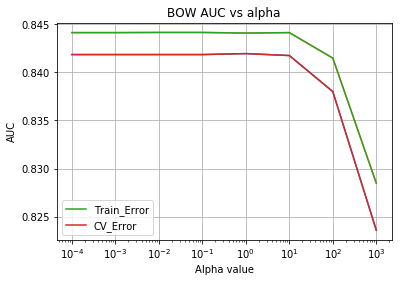

In [203]:
# plot misclassification error vs k 
plot_train_cv_error(returned_pram,returned_pram_train,'BOW AUC vs alpha',alpha)
plt.show()

Observation: We can see that when alpha value is low, the our model is overfitting, means high AUC on train data and less AUC on unseen data. As alpha increasing AUC on Unseen data increasing with best hyperparamter 1 after that model started underfitting so AUC on Test data started decreasing. Hence our best alpha is 1. 

Accuracy and AUC on Test data with best alpha

In [258]:
# best_alpha=returned_pram.get(max((k) for k in returned_pram.keys()))
# highest_auc=max((k) for k in returned_pram.keys())
# print("Best alpha value: ",best_alpha," with Highest AUC: ",highest_auc)

In [205]:
best_alpha=1
mnNB = MultinomialNB(alpha=best_alpha)
mnNB.fit(training_count, train_traget)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [206]:
# Prediction on Test data
pred = mnNB.predict(test_count)
acc = accuracy_score(test_target, pred, normalize=True) * float(100)
auc=roc_auc_score(test_target, pred)
print(" Alpha value: ",best_alpha," AUC: ",auc," Acc: ",acc)

 Alpha value:  1  AUC:  0.8380499999999999  Acc:  83.80499999999999


### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [207]:
# Please write all the code with proper documentation

print(mnNB.coef_.T.shape)
features=(count_vect.get_feature_names())
print(len(features))

(1000, 1)
1000


In [208]:
feature_data=pd.DataFrame(list(mnNB.coef_.T),columns=['Score'])
feature_data['Feature']=features
feature_data['Score_abs']=feature_data['Score'].abs()
feature_data.head()

,Score,Feature,Score_abs
0,-6.811714,abl,6.811714
1,-6.833893,absolut,6.833893
2,-8.535079,accord,8.535079
3,-7.582580,acid,7.582580
4,-8.169505,across,8.169505


In [209]:
# Top 10 feature for positive class
feature_data.sort_values(by='Score_abs',inplace=True,ascending=True)
feature_data[['Feature','Score_abs']].head(10)

,Feature,Score_abs
489,like,4.210910
868,tast,4.297013
374,good,4.432297
337,flavor,4.460861
382,great,4.497827
931,use,4.500493
505,love,4.505149
589,one,4.566053
871,tea,4.601502
674,product,4.660161


Observation: We can see that the positive feature for positive class is positive words like good, love great and so on.

### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [210]:
# Please write all the code with proper documentation
# Top 10 feature for negative class
feature_data.sort_values(by='Score_abs',inplace=True,ascending=False)
feature_data[['Feature','Score_abs']].head(10)

,Feature,Score_abs
869,tasteless,10.008893
707,refund,9.984795
908,trash,9.851264
85,bewar,9.830645
358,garbag,9.790639
890,threw,9.771221
981,worst,9.771221
258,disgust,9.644928
726,rip,9.563582
929,unpleas,9.445799


Observation: We can see that the important feature for negative class is negative words like trash, tasteless, which are expected to have.

In [211]:
# ROC AUC Curve


y_true_train = train_traget
y_probas_train = mnNB.predict_proba(training_count)
y_true_test = test_target
y_probas_test = mnNB.predict_proba(test_count)

In [212]:
def plot_train_test_ROC(y_true_train,y_probas_train,y_true_test,y_probas_test):
    fpr1, tpr1, _ = metrics.roc_curve(y_true_train,  y_probas_train[:,1])
    auc1 = metrics.roc_auc_score(y_true_train, y_probas_train[:,1])
    plt.plot(fpr1,tpr1,label="Train AUC, auc="+str(auc1))
    fpr2, tpr2, _ = metrics.roc_curve(y_true_test,  y_probas_test[:,1])
    auc2 = metrics.roc_auc_score(y_true_test, y_probas_test[:,1])
    plt.plot(fpr2,tpr2,label="Test, auc="+str(auc2))
    plt.legend(loc=4)
    plt.title("Train and Test AUC")
    plt.grid()
    plt.xlabel('False Positive rate')
    plt.ylabel('True positive rate')
    return plt
    

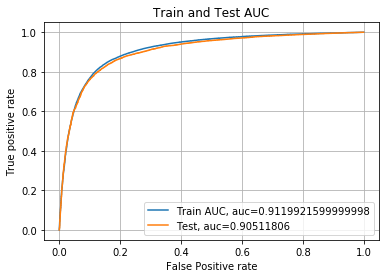

In [213]:
plot_train_test_ROC(y_true_train,y_probas_train,y_true_test,y_probas_test)
plt.show()

Observation: We can see that the Train and Test AUC is almost same on dest hyperparamter alpha =1. And the diff of train and Test AUC is not significant so we can say that this model is well fit. If we need better performance than this we may need to try different model and add some new features

In [214]:
# Plotting Confusion matrix on test data
import seaborn as sn
from sklearn.metrics import confusion_matrix
confm = confusion_matrix(y_true_test, mnNB.predict(test_count))

[Text(0,0.5,'0'), Text(0,1.5,'1')]

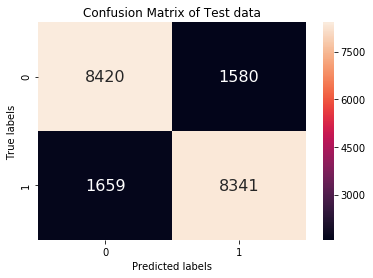

In [215]:
ax= plt.subplot()
sns.heatmap(confm, annot=True, ax = ax,annot_kws={"size": 16},fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of Test data'); 
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1'])

Observation: We can see that on unseen data(Test set) our diagonal elements have more no of count than off diagonals. means we have more TP and TN than FP and FN.

# Feature Engineering

- Creating 4 new features using word and character len of description and summary columns

In [216]:
import pandas as pd
data=pd.DataFrame(training_count)
data.head(3)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [217]:
data.shape

(60000, 1000)

In [218]:
#Train data
# word len of description and summary columns
data['description_len'] = train_data['CleanedText'].apply(lambda x : len(x.split()))
data['summary_len'] = train_data['Summary'].apply(lambda x : len(x.split()))

# charater len of description and summary columns
data['description_char_len'] = train_data['CleanedText'].apply(len)
data['Summary_char_len'] = train_data['Summary'].apply(len)


In [219]:
data.head(1)

,0,1,2,3,4,5,6,7,8,9,...,994,995,996,997,998,999,description_len,summary_len,description_char_len,Summary_char_len
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,11,1,61,5


In [220]:
data.shape

(60000, 1004)

In [221]:
#Test data
# word len of description and summary columns
data_test=pd.DataFrame(test_count)
data_test['description_len'] = test_data['CleanedText'].apply(lambda x : len(x.split()))
data_test['summary_len'] = test_data['Summary'].apply(lambda x : len(x.split()))

# charater len of description and summary columns
data_test['description_char_len'] = test_data['CleanedText'].apply(len)
data_test['Summary_char_len'] = test_data['Summary'].apply(len)
data_test.head(1)

,0,1,2,3,4,5,6,7,8,9,...,994,995,996,997,998,999,description_len,summary_len,description_char_len,Summary_char_len
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,29,2,163,7


In [222]:
data_test.shape

(20000, 1004)

In [223]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
best_alpha=10
mnNB = MultinomialNB(alpha=best_alpha)
mnNB.fit(data, train_traget)

MultinomialNB(alpha=10, class_prior=None, fit_prior=True)

In [224]:
pred_train = mnNB.predict(data)
acc_train = accuracy_score(train_traget, pred_train, normalize=True) * float(100)
auc_train=roc_auc_score(train_traget, pred_train)

pred_test = mnNB.predict(data_test)
acc_test = accuracy_score(test_target, pred_test, normalize=True) * float(100)
auc_test=roc_auc_score(test_target, pred_test)
print(" AUC_test: ",auc_test," Acc_test: ",acc_test)
print(" Auc_train: ",auc_train," Acc_train: ",acc_train)

 AUC_test:  0.8162999999999999  Acc_test:  81.63
 Auc_train:  0.8192166666666667  Acc_train:  81.92166666666667


Observation: After adding 4 more features, Test and train both AUC has decreased, this may be because we need to tune the hyper paramter again as feature has changed.

## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [226]:
# Please write all the code with proper documentation
# Taking only 10k points as it creating more than 500k dimensions
tf_idf_vect = TfidfVectorizer(ngram_range=(2,3),min_df=10,max_features=1000)
training_counts = tf_idf_vect.fit_transform(train_data['CleanedText'])
cv_counts = tf_idf_vect.transform(cv_data['CleanedText'])
test_counts = tf_idf_vect.transform(test_data['CleanedText'])


In [227]:
print(" training_counts ",training_counts.shape,"cv_counts ",cv_counts.shape,"test_counts",test_counts.shape)

 training_counts  (60000, 1000) cv_counts  (20000, 1000) test_counts (20000, 1000)


In [228]:
# converting sparse vector to dense vector
training_count=training_counts.toarray()

In [229]:
cv_count=cv_counts.toarray()
test_count=test_counts.toarray()
# removing unused object
gc.collect()

15582

In [230]:
train_data.shape

(60000, 12)

In [231]:
train_traget=train_data['Score'].astype('int')
cv_target=cv_data['Score'].astype('int')
test_target=test_data['Score'].astype('int')

In [232]:
# Compute train AUC also

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#Simple Cross Validation
alpha=[0.0001,0.001,0.01,0.1,1,10,100,1000,]
returned_pram=dict()
returned_pram_train=dict()
for i in tqdm(alpha):
    # instantiate learning model (k = 30)
    mnNB = MultinomialNB(alpha=i)

    # fitting the model on crossvalidation train
    mnNB.fit(training_count, train_traget)

    # predict the response on the crossvalidation train
    pred_cv = mnNB.predict(cv_count)

    # evaluate CV accuracy
    acc_cv = accuracy_score(cv_target, pred_cv, normalize=True) * float(100)
    auc_cv=roc_auc_score(cv_target, pred_cv)
    auc_train=roc_auc_score(train_traget, mnNB.predict(training_count))
    print(" Alpha value: ",i," AUC: ",auc_cv," Acc: ",acc_cv," auc_train ",auc_train)
    returned_pram.update({i:auc_cv})
    returned_pram_train.update({i:auc_train})
    gc.collect()
    

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

 Alpha value:  0.0001  AUC:  0.7443  Acc:  74.42999999999999  auc_train  0.7529333333333335


 12%|██████████▌                                                                         | 1/8 [00:01<00:12,  1.74s/it]

 Alpha value:  0.001  AUC:  0.7443  Acc:  74.42999999999999  auc_train  0.7529333333333335


 25%|█████████████████████                                                               | 2/8 [00:03<00:09,  1.60s/it]

 Alpha value:  0.01  AUC:  0.7443  Acc:  74.42999999999999  auc_train  0.7529666666666667


 38%|███████████████████████████████▌                                                    | 3/8 [00:04<00:07,  1.55s/it]

 Alpha value:  0.1  AUC:  0.7444  Acc:  74.44  auc_train  0.7529666666666667


 50%|██████████████████████████████████████████                                          | 4/8 [00:06<00:06,  1.52s/it]

 Alpha value:  1  AUC:  0.7448  Acc:  74.48  auc_train  0.7529999999999999


 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:07<00:04,  1.54s/it]

 Alpha value:  10  AUC:  0.7447  Acc:  74.47  auc_train  0.7525333333333334


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:09<00:03,  1.52s/it]

 Alpha value:  100  AUC:  0.7414499999999999  Acc:  74.14500000000001  auc_train  0.7482833333333334


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:10<00:01,  1.52s/it]

 Alpha value:  1000  AUC:  0.7334999999999999  Acc:  73.35000000000001  auc_train  0.7391833333333333


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:12<00:00,  1.51s/it]


In [233]:
# ROC AUC Curve
def plot_train_cv_error(test_map,train_map,title,alpha):
    plt.plot(list(test_map.keys()), test_map.values())
    plt.plot(list(train_map.keys()), train_map.values())
    plt.semilogx(alpha, train_map.values(), label='Train_Error')
    plt.semilogx(alpha, test_map.values(), label='CV_Error')
    plt.xlabel('Alpha value')
    plt.ylabel('AUC')
    plt.title(title)
    plt.legend()
    plt.grid()
    return plt

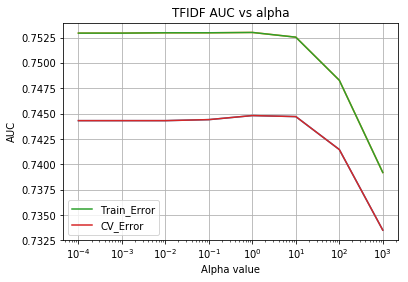

In [234]:
# plot misclassification error vs k 
plot_train_cv_error(returned_pram,returned_pram_train,'TFIDF AUC vs alpha',alpha)
plt.show()

Observation: We can see that as alpha value is low CV AUC is less and training AUC is more, this is because of overfitting on less alpha value. As we increasing the alpha, training AUC is decreasing and TEST AUC is increasing. At alpha value 1, we are getting Maximum AUC and after than model is underfitting. so our best alpha is 1.

Accuracy and AUC on Test data with best alpha

In [251]:
best_alpha=1
mnNB = MultinomialNB(alpha=best_alpha)
mnNB.fit(training_count, train_traget)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [252]:
# Prediction on Test data
pred = mnNB.predict(test_count)
acc = accuracy_score(test_target, pred, normalize=True) * float(100)
auc=roc_auc_score(test_target, pred)
print("Stats on Test data "," Alpha value: ",best_alpha," AUC: ",auc," Acc: ",acc)

Stats on Test data   Alpha value:  1  AUC:  0.7395  Acc:  73.95


In [237]:
# ROC AUC Curve
import scikitplot as skplt

y_true_train = train_traget
y_probas_train = mnNB.predict_proba(training_count)
y_true_test = test_target
y_probas_test = mnNB.predict_proba(test_count)

In [238]:
def plot_train_test_ROC(y_true_train,y_probas_train,y_true_test,y_probas_test):
    fpr1, tpr1, _ = metrics.roc_curve(y_true_train,  y_probas_train[:,1])
    auc1 = metrics.roc_auc_score(y_true_train, y_probas_train[:,1])
    plt.plot(fpr1,tpr1,label="Train AUC, auc="+str(auc1))
    fpr2, tpr2, _ = metrics.roc_curve(y_true_test,  y_probas_test[:,1])
    auc2 = metrics.roc_auc_score(y_true_test, y_probas_test[:,1])
    plt.plot(fpr2,tpr2,label="Test, auc="+str(auc2))
    plt.legend(loc=4)
    plt.title("TFIDF Train and Test AUC")
    plt.grid()
    plt.xlabel('False Positive rate')
    plt.ylabel('True positive rate')
    return plt

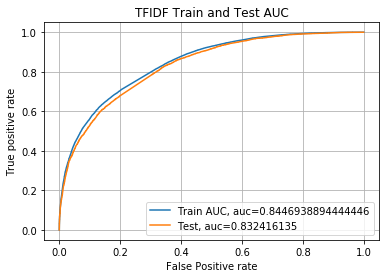

In [239]:
plot_train_test_ROC(y_true_train,y_probas_train,y_true_test,y_probas_test)
plt.show()

Observation: We can see that the ROC curve of the train and test data is almost same, means we are getting almost idle model. If we want to increase the accuracy we need to do feature engineering and add some new features.

In [240]:
# Plotting Confusion matrix on test data
import seaborn as sn
from sklearn.metrics import confusion_matrix
confm = confusion_matrix(y_true_test, mnNB.predict(test_count))

[Text(0,0.5,'0'), Text(0,1.5,'1')]

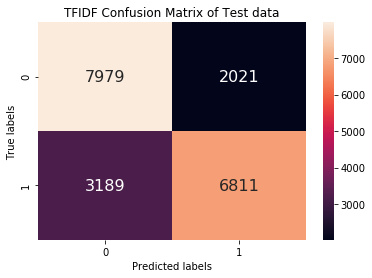

In [241]:
ax= plt.subplot()
sns.heatmap(confm, annot=True, ax = ax,annot_kws={"size": 16},fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('TFIDF Confusion Matrix of Test data'); 
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1'])

Observation: We can see that the diagonal elments have more number of correct prediction i.e TP and TN than the off digonal numbers i.e FP and FN. 

# Feature Engineering

- Creating 4 new features using words and characters len of description and summary columns

In [242]:
import pandas as pd
data=pd.DataFrame(training_count)
data.head(3)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [243]:
data.shape

(60000, 1000)

In [244]:
# word len of description and summary columns
data['description_len'] = train_data['CleanedText'].apply(lambda x : len(x.split()))
data['summary_len'] = train_data['Summary'].apply(lambda x : len(x.split()))

# charater len of description and summary columns
data['description_char_len'] = train_data['CleanedText'].apply(len)
data['Summary_char_len'] = train_data['Summary'].apply(len)
data.head(1)

,0,1,2,3,4,5,6,7,8,9,...,994,995,996,997,998,999,description_len,summary_len,description_char_len,Summary_char_len
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11,1,61,5


In [245]:
data.shape

(60000, 1004)

In [246]:
#Test data
# word len of description and summary columns
data_test=pd.DataFrame(test_count)
data_test['description_len'] = test_data['CleanedText'].apply(lambda x : len(x.split()))
data_test['summary_len'] = test_data['Summary'].apply(lambda x : len(x.split()))

# charater len of description and summary columns
data_test['description_char_len'] = test_data['CleanedText'].apply(len)
data_test['Summary_char_len'] = test_data['Summary'].apply(len)
data_test.head(1)

,0,1,2,3,4,5,6,7,8,9,...,994,995,996,997,998,999,description_len,summary_len,description_char_len,Summary_char_len
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,29,2,163,7


In [ ]:
# Testing on additional features

In [247]:
best_alpha=1
mnNB = MultinomialNB(alpha=best_alpha)
mnNB.fit(data, train_traget)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [248]:
pred_train = mnNB.predict(data)
acc_train = accuracy_score(train_traget, pred_train, normalize=True) * float(100)
auc_train=roc_auc_score(train_traget, pred_train)

pred_test = mnNB.predict(data_test)
acc_test = accuracy_score(test_target, pred_test, normalize=True) * float(100)
auc_test=roc_auc_score(test_target, pred_test)
print(" AUC_test: ",auc_test," Acc_test: ",acc_test)
print(" Auc_train: ",auc_train," Acc_train: ",acc_train)

 AUC_test:  0.73265  Acc_test:  73.265
 Auc_train:  0.7473333333333333  Acc_train:  74.73333333333333


Observation: After adding new features, performance of model has decreased to 0.73 from 0.82, may be we need to tune the alpha value on new data.

### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [253]:
# Please write all the code with proper documentation
print(mnNB.coef_.T.shape)
features=(tf_idf_vect.get_feature_names())
print(len(features))


(1000, 1)
1000


In [254]:
feature_data=pd.DataFrame(list(mnNB.coef_.T),columns=['Score'])
feature_data['Feature']=features
feature_data['Score_abs']=feature_data['Score'].abs()
feature_data.head()

,Score,Feature,Score_abs
0,-6.273892,abl find,6.273892
1,-6.949126,abl get,6.949126
2,-6.619455,absolut delici,6.619455
3,-5.830764,absolut love,5.830764
4,-6.848366,actual tast,6.848366


In [255]:
# Top 10 feature for positive class
feature_data.sort_values(by='Score_abs',inplace=True,ascending=True)
feature_data[['Feature','Score_abs']].head(10)

,Feature,Score_abs
431,high recommend,4.616764
815,tast great,4.841421
412,groceri store,4.915895
817,tast like,4.957956
814,tast good,5.060879
404,great product,5.124969
369,gluten free,5.202279
407,great tast,5.220992
461,ive tri,5.303238
411,green tea,5.335008


Observation: We can see that the features for positive review is positive words like "great","tast good" and so on, which expected to have.

### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [256]:
# Please write all the code with proper documentation
# Top 10 feature for positive class
feature_data.sort_values(by='Score_abs',inplace=True,ascending=False)
feature_data[['Feature','Score_abs']].head(10)

,Feature,Score_abs
958,worst tast,10.435733
274,extrem disappoint,10.221003
394,got bad batch,10.214020
231,dont wast money,10.127956
860,threw away,10.035414
726,return item,10.025566
572,money back,9.982682
898,two star,9.880105
703,realli disappoint,9.654705
746,send back,9.543017


Observation: We can see that the features for negative review is -ve words like "worst tast","disappoint" and so on, which are expected to have.

# [6] Conclusions

In [257]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Best alpha", "AUC"]

x.add_row(["BOW", "Multinomial NB", 10, 0.91])
x.add_row(["BOW_FeatureEngineering", "Multinomial NB", 10, 0.82])
x.add_row(["TFIDF", "Multinomial NB", 1, 0.84])
x.add_row(["TFIDF_FeatureEngineering", "Multinomial NB", 1, 0.73])
print(x)

+--------------------------+----------------+------------+------+
|        Vectorizer        |     Model      | Best alpha | AUC  |
+--------------------------+----------------+------------+------+
|           BOW            | Multinomial NB |     10     | 0.91 |
|  BOW_FeatureEngineering  | Multinomial NB |     10     | 0.82 |
|          TFIDF           | Multinomial NB |     1      | 0.84 |
| TFIDF_FeatureEngineering | Multinomial NB |     1      | 0.73 |
+--------------------------+----------------+------------+------+


Observation: After adding new features in both BOW and TFIDF, AUC value has reduced from 0.91 to 0.82 for BOW and 0.84 to 0.73 for TFIDF.